## Reference 보정을 이용한 AutoML

prototype 2-1에서 얻은 최선의 pipeline을 이용 -> 파장별 반사도 예측진행


- Thickness 까지 이용한 경우의 결과가 더 좋았음.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [3]:
wavelength_reflectance = pd.read_csv('./data/Wavelength_Reflectance.csv')
wavelength_reflectance.drop([33], inplace=True, axis=0)
wavelength_reflectance.reset_index(drop=True, inplace=True)
wavelength_reflectance

,1200,1195,1190,1185,1180,1175,1170,1165,1160,1155,...,345,340,335,330,325,320,315,310,305,300
0,42.8896,42.8803,42.8670,42.8363,42.8053,42.7561,42.6851,42.6006,42.5074,42.3830,...,17.2131,18.6438,20.3104,22.2471,24.4807,26.9655,29.7477,32.9686,36.7992,41.3415
1,41.5872,41.5717,41.5558,41.5110,41.4756,41.4237,41.3529,41.2664,41.1847,41.0704,...,17.1074,18.4520,20.1602,22.1066,24.3548,26.7889,29.6559,32.9009,36.5783,41.1869
2,42.9807,42.9700,42.9643,42.9260,42.9081,42.8387,42.7839,42.6806,42.5990,42.4763,...,16.7379,18.0661,19.6929,21.6427,23.9751,26.3148,29.1096,32.4474,36.0285,40.7427
3,39.2415,39.1803,39.1041,39.0124,38.9146,38.8205,38.7224,38.6092,38.4883,38.3309,...,11.3720,11.6736,12.1802,12.8054,13.5530,14.4224,15.4258,16.5176,17.6970,18.9095
4,41.9436,41.9261,41.9014,41.8590,41.8230,41.7490,41.6718,41.5448,41.4638,41.3088,...,37.5698,39.2331,41.2842,43.3325,45.5155,47.7558,50.1512,52.7172,55.7390,59.1903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,33.5573,33.5198,33.4513,33.3727,33.2746,33.1640,33.0726,32.9595,32.8137,32.6569,...,56.1097,54.6856,54.0541,53.5905,52.9249,52.1014,51.3680,50.3254,49.3006,48.2664
123,34.0645,34.0112,33.9303,33.8602,33.7540,33.6441,33.5091,33.3539,33.1958,33.0018,...,50.9823,48.2750,45.5476,42.6484,39.3928,35.6914,31.6697,27.5046,23.2754,19.4520
124,34.8708,34.8165,34.7457,34.6736,34.5668,34.4585,34.3171,34.1539,33.9888,33.7975,...,52.4914,50.0652,47.6259,45.0022,42.0583,38.6349,34.9992,31.0479,26.9193,22.8946
125,34.0294,33.9802,33.9047,33.8210,33.7155,33.6025,33.4832,33.3312,33.1706,32.9825,...,53.2491,50.9713,48.7654,46.3965,43.7082,40.5118,37.1455,33.4805,29.5099,25.6354


In [4]:
Table_dataset = pd.read_csv("./data/RGB.csv")
Table_dataset = pd.concat([Table_dataset, wavelength_reflectance], axis=1)
Table_dataset

,R,G,B,Thickness,1200,1195,1190,1185,1180,1175,...,345,340,335,330,325,320,315,310,305,300
0,11.576000,10.883200,8.136400,48.266667,42.8896,42.8803,42.8670,42.8363,42.8053,42.7561,...,17.2131,18.6438,20.3104,22.2471,24.4807,26.9655,29.7477,32.9686,36.7992,41.3415
1,10.826174,11.729849,9.594695,47.966667,41.5872,41.5717,41.5558,41.5110,41.4756,41.4237,...,17.1074,18.4520,20.1602,22.1066,24.3548,26.7889,29.6559,32.9009,36.5783,41.1869
2,13.336985,12.112036,8.233817,48.166667,42.9807,42.9700,42.9643,42.9260,42.9081,42.8387,...,16.7379,18.0661,19.6929,21.6427,23.9751,26.3148,29.1096,32.4474,36.0285,40.7427
3,9.354297,9.887613,6.912199,48.600000,39.2415,39.1803,39.1041,39.0124,38.9146,38.8205,...,11.3720,11.6736,12.1802,12.8054,13.5530,14.4224,15.4258,16.5176,17.6970,18.9095
4,4.799665,2.776091,1.086510,59.533333,41.9436,41.9261,41.9014,41.8590,41.8230,41.7490,...,37.5698,39.2331,41.2842,43.3325,45.5155,47.7558,50.1512,52.7172,55.7390,59.1903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.503564,4.690656,18.853995,84.633333,33.5573,33.5198,33.4513,33.3727,33.2746,33.1640,...,56.1097,54.6856,54.0541,53.5905,52.9249,52.1014,51.3680,50.3254,49.3006,48.2664
123,0.825026,14.850428,27.031939,98.366667,34.0645,34.0112,33.9303,33.8602,33.7540,33.6441,...,50.9823,48.2750,45.5476,42.6484,39.3928,35.6914,31.6697,27.5046,23.2754,19.4520
124,0.969714,13.035919,33.905851,97.033333,34.8708,34.8165,34.7457,34.6736,34.5668,34.4585,...,52.4914,50.0652,47.6259,45.0022,42.0583,38.6349,34.9992,31.0479,26.9193,22.8946
125,1.159944,13.412763,32.316093,96.266667,34.0294,33.9802,33.9047,33.8210,33.7155,33.6025,...,53.2491,50.9713,48.7654,46.3965,43.7082,40.5118,37.1455,33.4805,29.5099,25.6354


In [5]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [6]:
train_index = X_train.index
test_index = X_test.index

In [7]:
dt_train = pd.concat([X_train, y_train], axis=1)
dt_test = pd.concat([X_test, y_test], axis=1)

datalist = []
for i in train_index:
    for j in range(len(wavelength_reflectance.columns)):
        datalist.append([dt_train['R'][i], dt_train['G'][i], dt_train['B'][i], dt_train['Thickness'][i], wavelength_reflectance.columns[j], wavelength_reflectance.iloc[i, j]])

df_train = pd.DataFrame(datalist, columns=['R', 'G', 'B', 'Thickness', 'Wavelength', 'Reflectance'])


datalist = []
for i in test_index:
    for j in range(len(wavelength_reflectance.columns)):
        datalist.append([dt_test['R'][i], dt_test['G'][i], dt_test['B'][i], dt_test['Thickness'][i], wavelength_reflectance.columns[j], wavelength_reflectance.iloc[i, j]])

df_test = pd.DataFrame(datalist, columns=['R', 'G', 'B', 'Thickness', 'Wavelength', 'Reflectance'])
df_test

,R,G,B,Thickness,Wavelength,Reflectance
0,1.483631,0.996422,8.668116,75.533333,1200,37.0002
1,1.483631,0.996422,8.668116,75.533333,1195,36.9578
2,1.483631,0.996422,8.668116,75.533333,1190,36.9054
3,1.483631,0.996422,8.668116,75.533333,1185,36.8248
4,1.483631,0.996422,8.668116,75.533333,1180,36.7539
...,...,...,...,...,...,...
7054,0.292473,1.614227,10.790974,81.733333,320,57.4503
7055,0.292473,1.614227,10.790974,81.733333,315,57.3002
7056,0.292473,1.614227,10.790974,81.733333,310,57.1802
7057,0.292473,1.614227,10.790974,81.733333,305,57.1194


In [8]:
print(len(df_train), len(df_test))

15928 7059


### RGB + Thickness + Wavelength -> Reflectance

In [9]:
X_train = df_train.drop(['Reflectance'], axis=1)
y_train = df_train['Reflectance']

X_test = df_test.drop(['Reflectance'], axis=1)
y_test = df_test['Reflectance']

In [10]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('RGB_Thickness.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -6.339018051848359

Generation 2 - Current best internal CV score: -6.339018051848359

Generation 3 - Current best internal CV score: -6.339018051848359

Generation 4 - Current best internal CV score: -6.339018051848359

Generation 5 - Current best internal CV score: -6.250389554547568

Best pipeline: KNeighborsRegressor(LinearSVR(input_matrix, C=1.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.0001), n_neighbors=14, p=1, weights=distance)


In [11]:
y_pred = tpot.predict(X_test)
y_pred

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(


array([38.71644355, 38.57077433, 38.52188534, ..., 58.20497223,
       58.26903813, 55.54988886])

In [12]:
len(X_test)/len(wavelength_reflectance.columns)

39.0

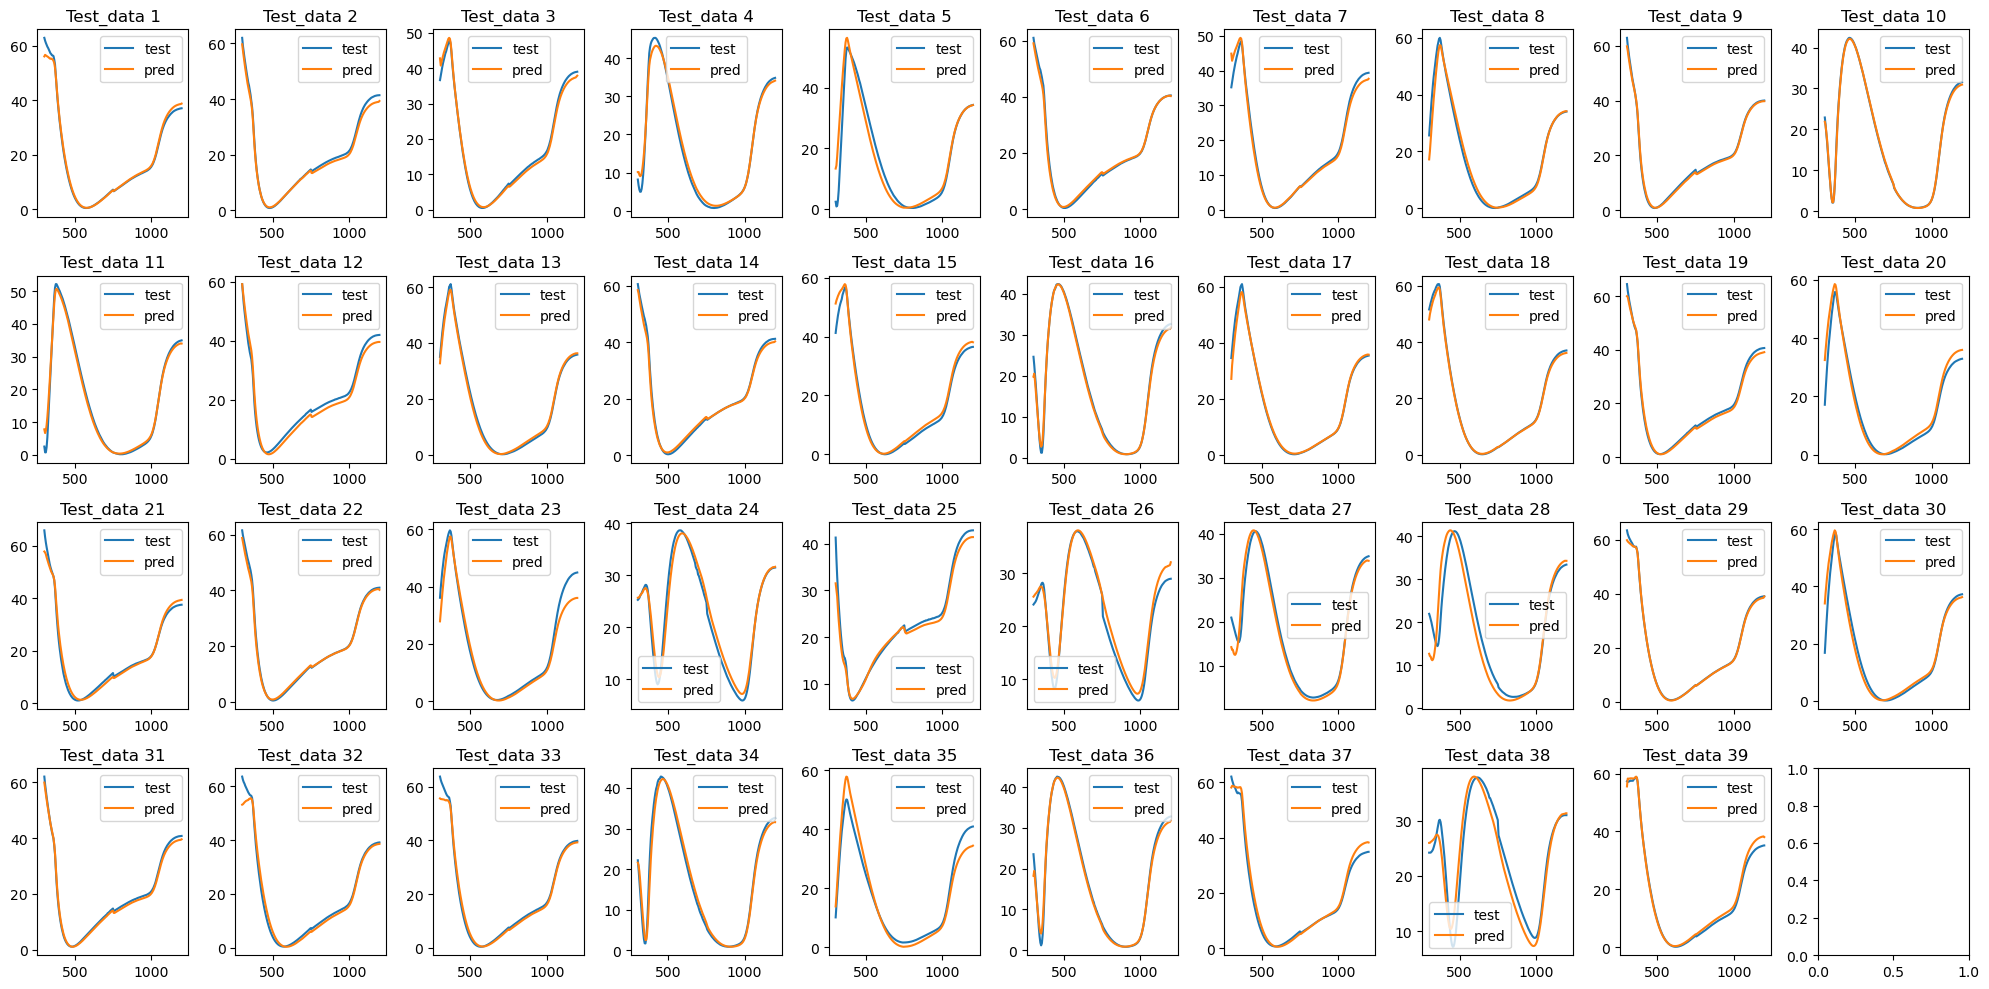

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have already loaded your data
# wavelength_reflectance_data = pd.read_csv("Wavelength_Reflectance.csv")
# y_test = ... (your test data)

# Using y_test values as dummy y_pred values for demonstration

# Extracting wavelength values for x-axis
wavelengths = wavelength_reflectance.columns.astype(float).values

# Plotting the graphs using the wavelengths as the x-axis
fig, axs = plt.subplots(4, 10, figsize=(20, 10))

num_plots = min(39, len(y_test) // 181)

for i in range(num_plots):
    j = i // 10
    k = i % 10
    axs[j, k].plot(wavelengths, y_test.values[i*181:(i+1)*181], label='test')
    axs[j, k].plot(wavelengths, y_pred[i*181:(i+1)*181], label='pred')
    axs[j, k].set_title(f"Test_data {i+1}")
    axs[j, k].legend()

# Adjusting the spacing between the plots
plt.tight_layout()

# Displaying the plots
plt.show()


In [16]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred}).to_csv('./data/results/RGB_Thickness.csv', index=False)

In [17]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,37.0002,38.716444
1,36.9578,38.570774
2,36.9054,38.521885
3,36.8248,38.455482
4,36.7539,38.371556
...,...,...
7054,57.4503,58.291912
7055,57.3002,58.257230
7056,57.1802,58.204972
7057,57.1194,58.269038


In [18]:
mse = np.mean((y_test.values - y_pred)**2)
mse

3.7654611366306767

### RGB + Wavelength -> Reflectance

In [19]:
X_train = df_train.drop(['Reflectance', 'Thickness'], axis=1)
y_train = df_train['Reflectance']

X_test = df_test.drop(['Reflectance','Thickness'], axis=1)
y_test = df_test['Reflectance']

X_train

,R,G,B,Wavelength
0,0.565206,1.822800,9.707431,1200
1,0.565206,1.822800,9.707431,1195
2,0.565206,1.822800,9.707431,1190
3,0.565206,1.822800,9.707431,1185
4,0.565206,1.822800,9.707431,1180
...,...,...,...,...
15923,1.045924,1.002824,7.112578,320
15924,1.045924,1.002824,7.112578,315
15925,1.045924,1.002824,7.112578,310
15926,1.045924,1.002824,7.112578,305


In [20]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=24, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('RGB.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -9.036406739829093

Generation 2 - Current best internal CV score: -9.036406739829093

Generation 3 - Current best internal CV score: -9.031821473675896

Generation 4 - Current best internal CV score: -9.031821473675896

Generation 5 - Current best internal CV score: -9.031821473675896

Best pipeline: RandomForestRegressor(KNeighborsRegressor(input_matrix, n_neighbors=14, p=2, weights=distance), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=18, min_samples_split=10, n_estimators=100)


In [21]:
y_pred = tpot.predict(X_test)
y_pred

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([38.64538958, 38.60913427, 38.56890968, ..., 47.37277928,
       46.78316482, 46.03366028])

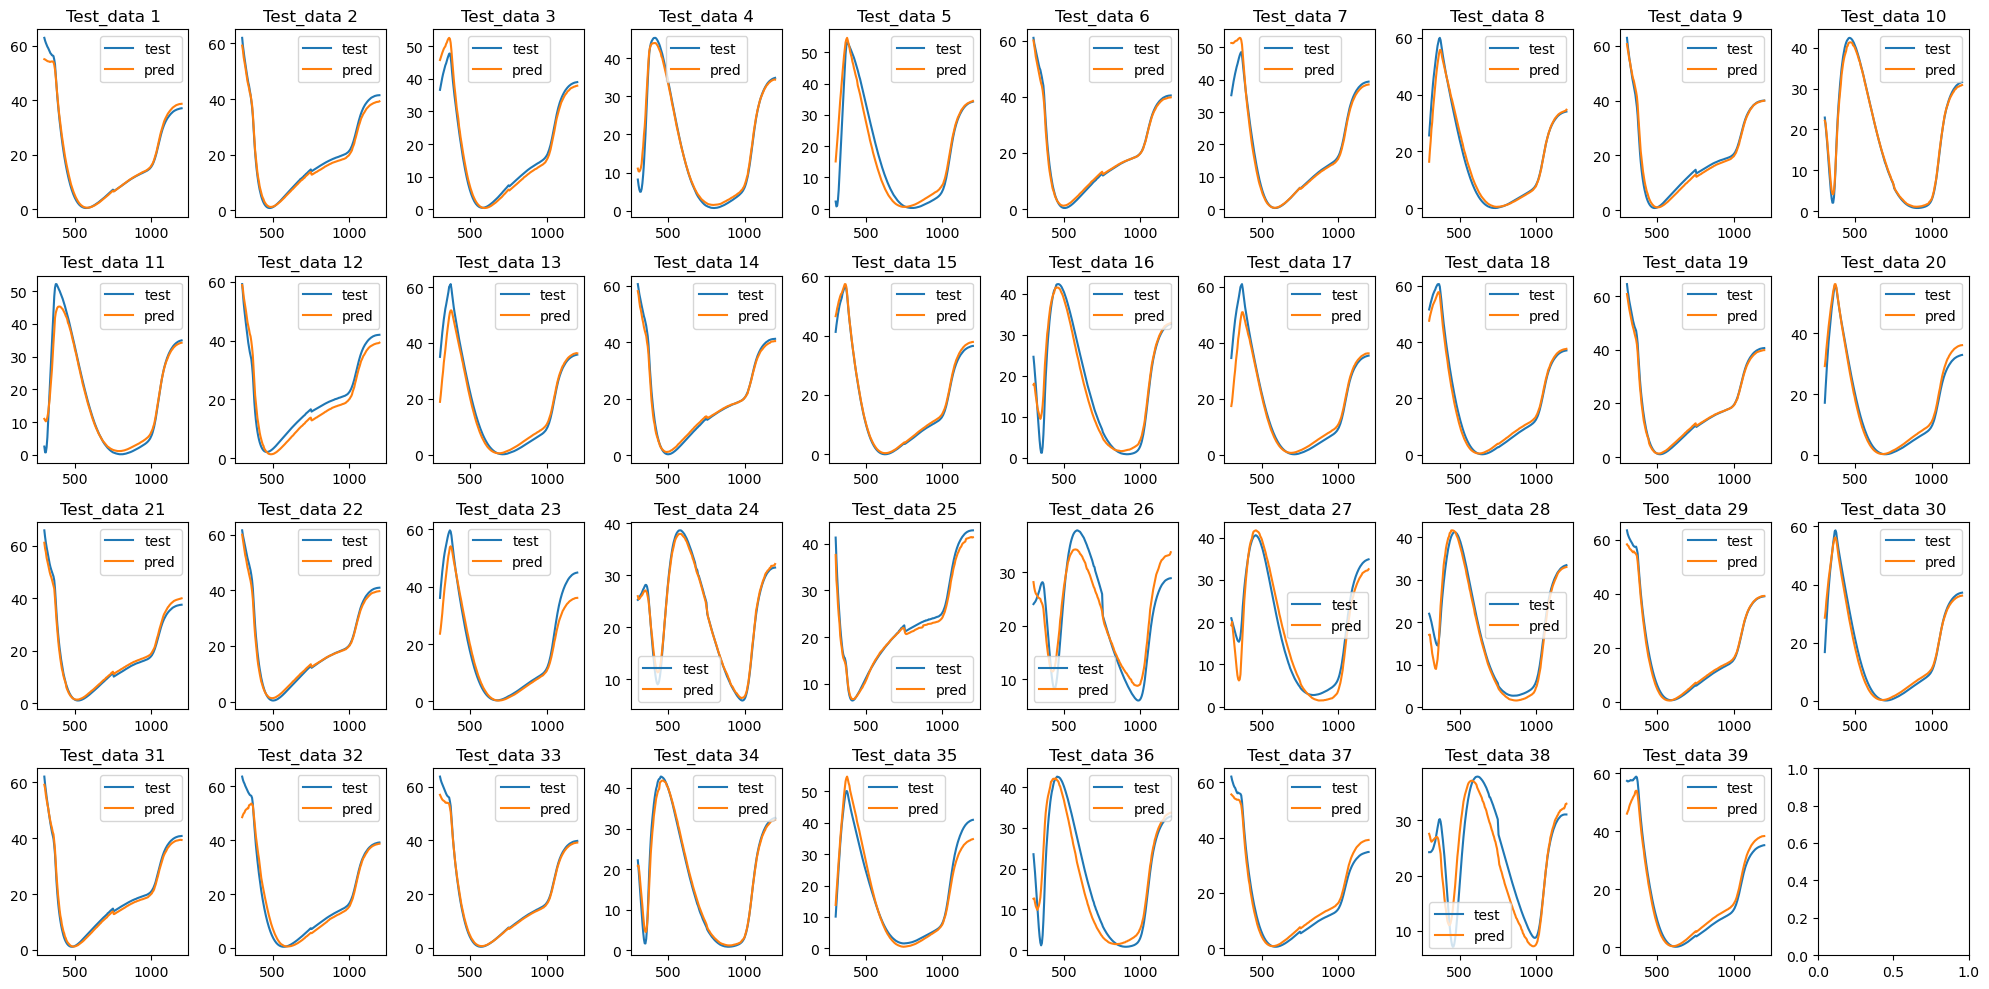

In [22]:
# Plotting the graphs using the wavelengths as the x-axis
fig, axs = plt.subplots(4, 10, figsize=(20, 10))

num_plots = min(39, len(y_test) // 181)

for i in range(num_plots):
    j = i // 10
    k = i % 10
    axs[j, k].plot(wavelengths, y_test.values[i*181:(i+1)*181], label='test')
    axs[j, k].plot(wavelengths, y_pred[i*181:(i+1)*181], label='pred')
    axs[j, k].set_title(f"Test_data {i+1}")
    axs[j, k].legend()

# Adjusting the spacing between the plots
plt.tight_layout()

# Displaying the plots
plt.show()




In [23]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred}).to_csv('./data/results/RGB.csv', index=False)

In [24]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,37.0002,38.645390
1,36.9578,38.609134
2,36.9054,38.568910
3,36.8248,38.533217
4,36.7539,38.429273
...,...,...
7054,57.4503,49.285142
7055,57.3002,48.470060
7056,57.1802,47.372779
7057,57.1194,46.783165


In [25]:
mse = np.mean((y_test.values - y_pred)**2)
mse

6.910660171091027